## Classification Task (XOR Classification)

In this notebook a classification task based on the XOR (www. function is presented. 


#### The procedure is the following:
* Generate a data set containing two classes which are not linearly separable
* By the variable 'center_gap' the overlap of the two classes can be modified
* Visualize sampled data set
* Train a linear classifier and evaluate the results
* Train a non-linear classifier and evaluate the results


#### Self-study [20min]:
* Go through notebook on your own and work on tasks presented in the end of the notebook

### Import needed packages

In [1]:
import random
import torch
from torch import nn, optim
from IPython import display
import numpy as np
import time
from matplotlib import pyplot as plt
from res.plot_lib import set_default

# Initial Setup

In [2]:
set_default()
seed = 42
random.seed(seed)
torch.manual_seed(seed);

### Define Pytorch Device: GPU if available, else use CPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Set Notebook Parameters

In [4]:
center_gap = 6         # Distance between cluster centers of the data set
num_samples = 2500     # Number of samples included in the data set
num_of_classes = 2     # Number of classes in the data set
val_left_out = 0.2     # Fraction of data set used for validation

H = 10                 # Number of hidden unites in the Neural Netowrk
num_out = 1            # Number of outputs in the neural network (Binary classifier needs only one output)

# Create Data Set

### Gerate XOR Data Set with Four Clusters

In [5]:
# Sample from 2 dimensinal normal distribution
X = torch.normal(mean=0, std=1, size=(num_samples,2))

# Sample cluster ids randomly from {0,1,2,3}
cluster_id = torch.randint(low=0,high=4, size=(num_samples,))

# Transform data point to receive four clusters
#      odd cluster_id   -->  shift x value by center_gap
#      cluster_id >= 2  -->  shift y value by center_gap
X = torch.stack([X[:,0] + center_gap * (cluster_id % 2), 
                 X[:,1] + center_gap * (cluster_id / 2)], axis=-1)

# Map cluster_ids to class labels: 
#      cluster_ids 0 and 3 --> 0
#      cluster_ids 1 and 4 --> 1
Y = torch.where((cluster_id == 0) + (cluster_id == 3) > 0, 
                torch.zeros_like(cluster_id), 
                torch.ones_like(cluster_id)).type(torch.FloatTensor)
Y = torch.unsqueeze(Y, axis=-1)


# Split data into training and validation set
split_id = int(num_samples*val_left_out)
cluster_id_train = cluster_id[split_id:]
X_train = X[split_id:]
Y_train = Y[split_id:]
cluster_id_val = cluster_id[:split_id]
X_val = X[:split_id]
Y_val = Y[:split_id]

### Print Data Set Properties

In [6]:
print("Shapes:")
print("X_train:", tuple(X_train.size()))
print("Y_train:", tuple(Y_train.size()))
print("Cluster Ids Training:", torch.unique(cluster_id_train,return_counts=True))
print("X_val:  ", tuple(X_val.size()))
print("Y_val:  ", tuple(Y_val.size()))
print("Cluster Ids Validation:", torch.unique(cluster_id_val,return_counts=True))

Shapes:
X_train: (2000, 2)
Y_train: (2000, 1)
Cluster Ids Training: (tensor([0, 1, 2, 3]), tensor([498, 492, 509, 501]))
X_val:   (500, 2)
Y_val:   (500, 1)
Cluster Ids Validation: (tensor([0, 1, 2, 3]), tensor([131, 116, 121, 132]))


### Plot Data Sets

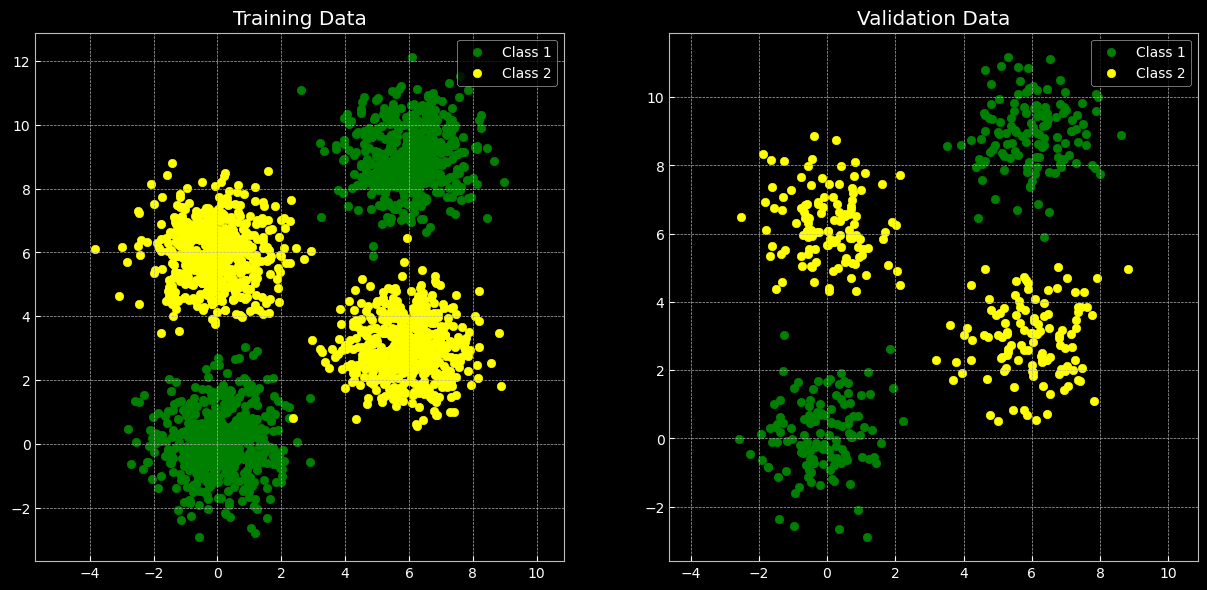

In [7]:
fig = plt.figure(figsize=(15, 7))

# Plot Training Data
fig.add_subplot(1, 2, 1)
plt.scatter(X_train.cpu()[Y_train[:,0]==0,0].numpy(), X_train.cpu()[Y_train[:,0]==0,1].numpy(), color="green", label="Class 1")
plt.scatter(X_train.cpu()[Y_train[:,0]==1,0].numpy(), X_train.cpu()[Y_train[:,0]==1,1].numpy(), color="yellow", label="Class 2")
plt.legend(loc='upper right')
plt.axis('equal');
plt.title('Training Data');

# Plot Validation Data
fig.add_subplot(1, 2, 2)
plt.scatter(X_val.cpu()[Y_val[:,0]==0,0].numpy(), X_val.cpu()[Y_val[:,0]==0,1].numpy(), color="green", label="Class 1")
plt.scatter(X_val.cpu()[Y_val[:,0]==1,0].numpy(), X_val.cpu()[Y_val[:,0]==1,1].numpy(), color="yellow", label="Class 2")
plt.legend(loc='upper right')
plt.axis('equal');
plt.title('Validation Data');

# Train and Evaluate Classifiers

We now build, train and evaluate a linear classifier and a non-linear neural network

## Linear Classifier

For the linear classifier, we train 5 networks and compare the resulting predictions by visualization of the predictions on the validation data set.

### Setup

In [8]:
learning_rate = 1e-3
max_epochs  = 500                # Maximum number of epochs to train
num_networks = 5                 # Number of networks to be trained
models = []                      # Empty list to be filled with trained models
criterion = torch.nn.BCELoss()   # Use binary-cross-entropy as loss function

### Build Neural Network without Non-Linearities
* Use nn package to create our linear model
* The network consists of H hidden units
* Each Linear module has a weight and bias
* Apply sigmoid on output to receive a probability value

In [9]:
def build_model_linear():
    model = nn.Sequential(
        nn.Linear(2, H),
        nn.Linear(H, 1),
        nn.Sigmoid()      # Sigmoid function to receive probabilities
    )
    
    return model

In [10]:
print(build_model_linear())

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
  (2): Sigmoid()
)


### Train the Neural Network without Non-Linearities
* Train 'num_networks' networks 
* Use the binary-cross-entropy as loss function 

In [11]:
models = []
 
# Iterate through number of networks
for n in range(num_networks):
    torch.manual_seed(seed + n);
    model = build_model_linear()
    model.to(device)       # move model to device
    models.append(model)

    # we use the optim package to apply stochastic gradient descent for our parameter updates
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)   
    
    for t in range(max_epochs):

        # Feed forward to get prediction
        y_pred_prob = model(X_train)

        # Compute the loss (Binary-Cross-Entropy)
        loss = criterion(y_pred_prob, Y_train)

        # Print current progress
        print("[MODEL]: %i, [EPOCH]: %i, [LOSS]: %.6f" % (n+1, t, loss.item()))
        display.clear_output(wait=True)
        
        # zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()

        # Update model parameters
        optimizer.step()

[MODEL]: 5, [EPOCH]: 499, [LOSS]: 0.694040


### Plot Predictions of Validation Set for each Model

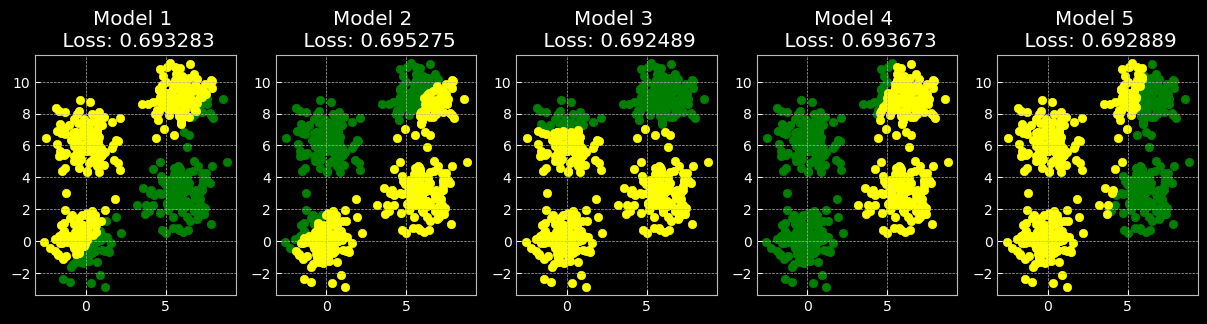

In [12]:
fig = plt.figure(figsize=(15, 7))
rows = 2
columns = 5

for i, m in enumerate(models):
    fig.add_subplot(rows, columns, i+1)
    
    y_pred_prob = m(X_val)
    y_pred = torch.round(y_pred_prob)

    plt.scatter(X_val.cpu()[y_pred[:,0]==1, 0].numpy(), X_val.cpu()[y_pred[:,0]==1, 1].numpy(), color="green")
    plt.scatter(X_val.cpu()[y_pred[:,0]==0, 0].numpy(), X_val.cpu()[y_pred[:,0]==0, 1].numpy(), color="yellow")
    plt.axis('equal')
    plt.title('Model %i \n Loss: %f' %(i+1, criterion(y_pred_prob, Y_val)))

# Excercises
* Reduce the number of training samples and retrain the model. What do you expect to happen? What can you see?
* Reduce the gap between the centers. The overlapping of the classes increases. What happens to the variety of the trained models? 

## Exercise 1: Two-Layered Non-Linear Network

In this excercise you extend the above presented examples to a non-linear classifier. This can be realized by adding different non-linearities to the model description. 

Go through the code below and fill the missing parts by parts (marked as '???') such that 
* the code trains 5 different networks
* add the Tanh non-linearity (nn.Tanh()) to the network architecture
* 



For the non-linear classifier, we train 5 networks and compare the resulting predictions by visualization of the predictions on the validation data set

### Setup

In [23]:
learning_rate = 1e-1
max_epochs  = 500                # Maximum number of epochs to train
num_networks = ???               # Number of networks to be trained
models = []                      # Empty list to be filled with trained models
criterion = torch.nn.BCELoss()   # Use binary-cross-entropy as loss function

### Build Neural Network with Non-Linearities
* Use nn package to create our linear model
* The network consists of H hidden units
* Each Linear module has a weight and bias
* Apply sigmoid on output to receive a probability value

In [24]:
def build_model():
    model = nn.Sequential(
        nn.Linear(2, H),
        ???
        nn.Linear(H, H),
        ???
        nn.Linear(H, 1),
        nn.Sigmoid()      # Sigmoid function to receive probabilities
    )
    
    return model

In [25]:
print(build_model())

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Tanh()
  (3): Linear(in_features=10, out_features=1, bias=True)
  (4): Sigmoid()
)


### Train the Neural Network with Non-Linearities
* Train 'num_networks' networks 
* Use the binary-cross-entropy as loss function 

In [26]:
models = []

# Iterate through number of networks
for n in range(num_networks):
    
    torch.manual_seed(seed + n);
    model = build_model()
    model.to(device)       # move model to device
    models.append(model)

    # we use the optim package to apply
    # stochastic gradient descent for our parameter updates
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)   
    
    for t in range(max_epochs):

        # Feed forward to get prediction
        y_pred_prob = model(X_train)

        # Compute the loss (Binary-Cross-Entropy)
        loss = criterion(y_pred_prob, Y_train)

        # Print current progress
        print("[MODEL]: %i, [EPOCH]: %i, [LOSS]: %.6f" % (n+1, t, loss.item()))

        display.clear_output(wait=True)
        
        # zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()


        # Update model parameters
        optimizer.step()

[MODEL]: 5, [EPOCH]: 499, [LOSS]: 0.068449


In [17]:
print(models[0])

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)


### Plot Predictions of Validation Set for each Model

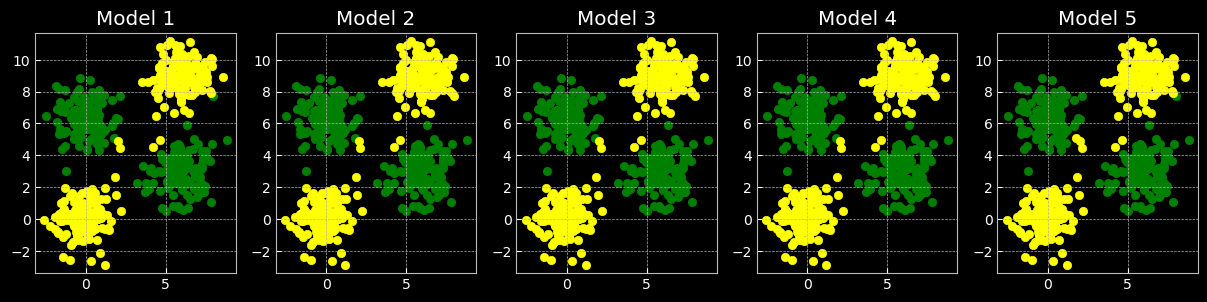

In [18]:
def plot_data(models, X_val):
    fig = plt.figure(figsize=(15, 7))
    rows =2
    columns = 5

    for i, m in enumerate(models):
        fig.add_subplot(rows, columns, i+1)
    
        y_pred = torch.round(m(X_val))

        plt.scatter(X_val.cpu()[y_pred[:,0]==1, 0].numpy(), X_val.cpu()[y_pred[:,0]==1, 1].numpy(), color="green")
        plt.scatter(X_val.cpu()[y_pred[:,0]==0, 0].numpy(), X_val.cpu()[y_pred[:,0]==0, 1].numpy(), color="yellow")
        plt.axis('equal')
        plt.title('Model %i' %(i+1))
        
predict_and_plot(models, )

In [19]:
center_gap = 6         # Distance between cluster centers of the data set
num_samples = 2500     # Number of samples included in the data set
num_of_classes = 2     # Number of classes in the data set
val_left_out = 0.2     # Fraction of data set used for validation

H = 10                 # Number of hidden unites in the Neural Netowrk
num_out = 1            # Number of outputs in the neural network (Binary classifier needs only one output)

In [20]:
print("Shapes:")
print("X_train:", tuple(X_train.size()))
print("Y_train:", tuple(Y_train.size()))
print("Cluster Ids Training:", torch.unique(cluster_id_train,return_counts=True))
print("X_val:  ", tuple(X_val.size()))
print("Y_val:  ", tuple(Y_val.size()))
print("Cluster Ids Validation:", torch.unique(cluster_id_val,return_counts=True))

Shapes:
X_train: (2000, 2)
Y_train: (2000, 1)
Cluster Ids Training: (tensor([0, 1, 2, 3]), tensor([498, 492, 509, 501]))
X_val:   (500, 2)
Y_val:   (500, 1)
Cluster Ids Validation: (tensor([0, 1, 2, 3]), tensor([131, 116, 121, 132]))
